# Filter Functions

are a great mathematical tool to calculate the influence of classical noise
with a
given spectral noise density on a quantum gate. Especially for small systems
and high noise frequencies,
the simulation with filter functions is much more efficient than a monte carlo
simulation and more general than a Lindblad master equation.

The implementation of filter functions is imported from the package
`filter_functions` 
[available on github](https://github.com/qutech/filter_functions). You can find
additional literature on filter functions in the following papers.

[T. Hangleiter, P. Cerfontaine, and H. Bluhm. Filter-function formalism and
software package to compute quantum processes of gate sequences for classical
non-Markovian noise. Phys. Rev. Res. **3**, 043047 (2021).
[10.1103/PhysRevResearch.3.043047](https://doi.org/10.1103/PhysRevResearch.3.043047).
[arXiv:2103.02403](https://arxiv.org/abs/2103.02403).

P. Cerfontaine, T. Hangleiter, and H. Bluhm. Filter Functions for Quantum
Processes under Correlated Noise. Phys. Rev. Lett. **127**, 170403 (2021).
[10.1103/PhysRevLett.127.170403](https://doi.org/10.1103/PhysRevLett.127.170403).
[arXiv:2103.02385](https://arxiv.org/abs/2103.02385).


## Example System

Lets consider the example of a singlet-triplet qubit. In this encoding of a
semiconductor spin qubit, two electrons are confined in a double quantum dot
subjected to a magnetic field. The computational states are the spin states of
zero total spin along the quantization axis $\vert \uparrow \downarrow>$ and
$\vert \downarrow \uparrow>$. The Hamiltonian consists is then written as

\begin{equation}
H=\Delta B_z \sigma_z + J(\epsilon(t))\sigma_x
\end{equation}

with the magnetic field gradient $\Delta B_z$ across the double quantum dot and
the exchange interaction $J(\epsilon(t)) = e^{\epsilon(t)}$ depending on the difference in
chemical potential $\epsilon(t)$. This potential $\epsilon$ is electrically
controlled to drive qubit rotations while the magnetic gradient establishes the
drift dynamics, and we identify the drift Hamiltonian
$H_d = \Delta B_z \sigma_z$ and the control Hamiltonian
$H_c = \sum_k u_k(t) A_k = J(\epsilon(t))\sigma_x$ with the only control amplitude
$u_k = J(\epsilon(t))$ depending on the optimization parameter $v=\epsilon$.

In [51]:
from qopt import *
import numpy as np
import matplotlib.pyplot as plt
import filter_functions as ff

delta_b_z = 2

n_time_steps = 50
delta_t = .2

def exchange_energy(epsilon):
    return np.exp(epsilon)

def deriv_exchange_energy(epsilon):
    return np.exp(epsilon)

amplitude_function = UnaryAnalyticAmpFunc(
    value_function=exchange_energy,
    derivative_function=deriv_exchange_energy
)

h_drift = [.5 * delta_b_z * DenseOperator.pauli_z()]
h_ctrl = [.5 * DenseOperator.pauli_x()]


## Calculate Filter Functions

We will now discuss how to calculate filter function with the qopt interface.

Any noise on the electrical control $\epsilon(t)
\rightarrow \epsilon(t) + \delta \epsilon(t)$ couples to the qubit via the
noise hamiltonian

\begin{equation}
H_n= \delta \epsilon(t) \frac{\partial J(\epsilon(t))}{\partial \epsilon}\sigma_x.
\end{equation}

The argument `filter_function_h_n` contains the noise Hamiltonian which must be
of the form

\begin{equation}
H_n=\sum_k s_k b_k B_k.
\end{equation}

where $s_k$ is the noise susceptibility, $b_k$ is the noise amplitude and
$B_k$ the operator coupling to the system. In this example we just have a
single term with $s=\frac{\partial J(\epsilon(t))}{\partial \epsilon}$,
$b=\delta \epsilon$ and $B=\sigma_x$.

The argument `filter_function_h_n` must be given as callable in this example,
because depends on the control amplitudes and is not constant. It is given
as function receiving three arguments:
1. Optimization Parameters: The parameters that are set to the solver.
2. Transferred Parameters: These are the optimization parameters after the
transfer function has been applied. (See also the section about transfer
functions.)
3. Control Amplitudes: These are calculated by applying the transfer function
and the amplitude function. (See also the section about the amplitude
function.)

In this example, we do not use a transfer function and hence the first two
arguments are equal.

In [52]:
# The filter function noise Hamiltonian can also be set statically, if it does
# not depend on the control amplitudes.
def filter_function_h_n(opt_pars, tr_pars, ctrl_amps):
    return [[
    .5 * DenseOperator.pauli_z(),
    deriv_exchange_energy(opt_pars)[:, 0],
    'Electric Noise'
]]

In the next section, we also want to use the filter functions for optimal
control and with analytic
gradients, and the calculation of the derivative of the filter function needs
the derivative of the noise susceptibility
$s=\frac{\partial J(\epsilon(t))}{\partial \epsilon}=\frac{\partial e^{
\epsilon(t)}}{\partial \epsilon} = e^{\epsilon(t)} = J$ by the control
amplitudes, which is
$\frac{\partial s}{\partial u}=\frac{\partial J(\epsilon(t))}{\partial J(\epsilon(t))}=1$.
It might feel unintuitive that we need the derivative by the control amplitudes
$\frac{\partial s}{\partial u}$
and not directly by the optimization parameter
$\frac{\partial x}{\partial v}$, but this is required by the structure of qopt,
because qopt first calculates the derivatives of the cost functions by the
control amplitudes and then uses automatically the transfer and the amplitude
function to calculate the derivatives by the optimization parameters.
This information is given to the solver in the argument
`filter_function_n_coeffs_deriv`, which has the same signature as
`filter_function_h_n`.


In [53]:
def filter_function_n_coeffs_deriv(opt_pars, tr_pars, ctrl_amps):
    derivatives = np.ones_like(opt_pars)
    derivatives = np.expand_dims(derivatives.T, axis=0)  # Additional axis for
    # the number of noise operators
    return derivatives

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=delta_t * np.ones(n_time_steps),
    amplitude_function=amplitude_function,
    filter_function_h_n=filter_function_h_n,
    filter_function_n_coeffs_deriv=filter_function_n_coeffs_deriv
)
np.random.seed(0)
ctrl_amplitudes = np.random.rand(n_time_steps, 1) - .5
solver.set_optimization_parameters(ctrl_amplitudes)

We can create an instance of the `PulseSequence` class, and use all the
functionalities of the `filter_functions` package:

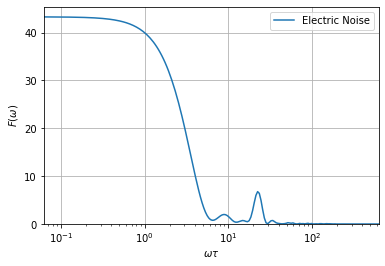

In [54]:
solver.create_pulse_sequence()
pulse_sequence = solver.pulse_sequence
omega = ff.util.get_sample_frequencies(
    pulse_sequence, n_samples=200, spacing='log')
_ = ff.plotting.plot_filter_function(pulse_sequence, omega)

But the calculation of the infidelity is also completely capsulated by the cost
function `OperatorFilterFunctionInfidelity`, which also holds the information
about the power spectral density of our noise souce:

\begin{equation}
S(f) = \int <b(0) b(t)> e^{2 \pi f t} dt = \int <\delta \epsilon(0) \delta \epsilon(t)> e^{2 \pi f t} dt
\end{equation}

In [55]:
def psd(f):
    return 1e-3/f

ff_infid = OperatorFilterFunctionInfidelity(
    solver=solver,
    noise_power_spec_density=psd,
    omega=omega,
    label=['FF Infidelity', ]
)
ff_infid.costs()

array([0.01301858])

## Optimal Control with Filter Functions

With the implementation of
Analytic Filter-Function Derivatives for Quantum Optimal Control,
filter functions are available as efficient tool in quantum optimal control.
The derivatives allow us to optimize pulses with cost functions defined by
filter functions. This enables the numeric calculations of pulses that are
especially robust towards noise of specific frequencies.


I. N. M. Le, J. D. Teske, T. Hangleiter, P. Cerfontaine, and Hendrik
Bluhm. Analytic Filter Function Derivatives for Quantum Optimal Control. Phys.
Rev. Applied **17**, 024006 (2022).
[10.1103/PhysRevApplied.17.024006](https://doi.org/10.1103/PhysRevApplied.17.024006).
[arXiv:2103.09126](https://arxiv.org/abs/2103.09126).

Optimal control with filter functions can also be used in noise spectroscopy
since it is possible to optimize
pulses to be susceptibile to a specific noise frequency.

We optimize a pulse for the example above:

In [56]:
# We need to add another cost function to set a target gate for the coherent
# evolution in the absence of noise.
coherent_costs = OperationInfidelity(
    solver=solver,
    target=DenseOperator.pauli_x()
)

simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[ff_infid, coherent_costs]
)

It is always a good advice to check the implementation of derivatives by
comparing the analytic to numeric gradients. The Simulator has a convenience
function to calculate the absolute and relative deviation of both:

In [57]:
print(simulator.compare_numeric_to_analytic_gradient(ctrl_amplitudes))



(5.461379710836878e-08, 1.8217219314791737e-07)


From the comparison of analytic and numeric gradients, we know that our
implementation is correct. Next we optimize the pulse.

In [58]:
optimizer = ScalarMinimizingOptimizer(
    system_simulator=simulator
)
result = optimizer.run_optimization(ctrl_amplitudes)

Lets plot the results of the optimization:

<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

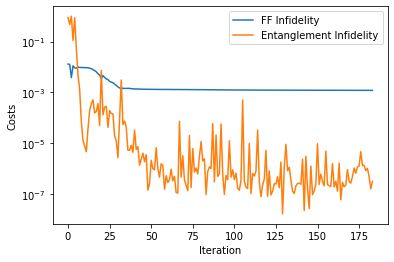

In [59]:
data = DataContainer()
data.append_optim_result(result)
analyser = Analyser(data)
analyser.plot_costs()

The Infidelity contribution of the 1/f-noise has dropped substantially. We
plot again the filter function and the pulse.

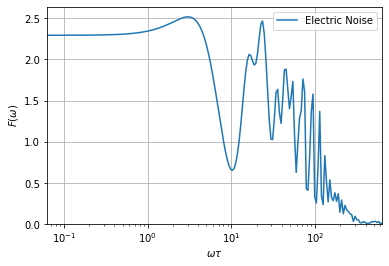

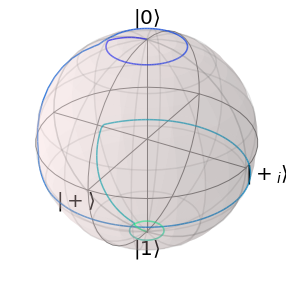

In [60]:
pulse_sequence2 = solver.create_pulse_sequence(result.final_parameters)
ff.plotting.plot_filter_function(pulse_sequence2, omega)

solver.plot_bloch_sphere()